In [33]:
#from operator import add
#from astropy import units as u
#from astropy.coordinates import SkyCoord
#from astropy.stats import LombScargle
#from gatspy.periodic import LombScargleFast
#from functools import partial
#from gatspy import periodic
import matplotlib.pyplot as plt
#from matplotlib.font_manager import FontProperties
import lomb_scargle_multiband as periodic
#from multiprocessing import Pool
import numpy as np
import os
#from sqlite3 import *
import random
from random import shuffle
from random import randint
import Observations
import Magnitudes
import simulate_lc as lc_sim
#import time

In [34]:
# LSST zero points  u,g,r,i,z,y
zeroPoints = [0,26.5,28.3,28.13,27.79,27.4,26.58]
FWHMeff = [0.8,0.92,0.87,0.83,0.80,0.78,0.76] # arcmins?
pixelScale = 0.2
readOut = 12.7
sigSys = 0.005
flareperiod = 1024
flarecycles = 10
dayinsec=86400
background = 40
# sat mag u,g,r,i,z,y=14.7,15.7,15.8,15.8,15.3 and 13.9
# start date 59580.033829 end date + 10 years
#maglist=[20]*7

lim = [0, 23.5, 24.8, 24.4, 23.9, 23.3, 22.1] # limiting magnitude ugry
sat = [0, 14.7, 15.7, 15.8, 15.8, 15.3, 13.9] # sat mag as above


# In[15]:


looooops = 1
maglength = 5
freqlength = 5
processors = 5

startnumber = 0 + 0                  
endnumber = startnumber + 1

#observingStrategy = 'minion'
observingStrategy = 'astroD'
#observingStrategy = 'panstars'



inFile = '/home/mj1e16/periodic/in'+str(startnumber)+'.txt'
outFile = '/home/mj1e16/periodic/outminion630'+str(startnumber)+'.txt'

#inFile = '/home/ubuntu/vagrant/'+observingStrategy+'/in'+observingStrategy+'KtypefullresultsFile'+str(startnumber)+'.txt'
#outFile = '/home/ubuntu/vagrant/'+observingStrategy+'/out'+observingStrategy+'KtypefullresultsFile'+str(startnumber)+'.txt'


#obs = Observations.obsastro630
obs = np.linspace(59630.320217,59630.320217+(365.25*10),100000)
#obs = obs.tolist()
obs = [obs]*7
obs = np.asarray(obs)

# for y in range(len(obs)):
#     obs[y] = [x + random.random() for x in obs[y]]

#In[19]:

In [35]:
random.random()

0.44939358867342394

In [36]:
def magUncertainy(Filter, objectmag, exposuretime,background, FWHM): # b is background counts per pixel   
    countsPS = 10**((Filter-objectmag)/2.5)
    counts = countsPS * exposuretime
    uncertainty = 1/(counts/((counts/2.3)+(((background/2.3)+(12.7**2))*2.266*((FWHM/0.2)**2)))**0.5) # gain assumed to be 1
    return uncertainty
#from lsst should have got the website! https://smtn-002.lsst.io/


def averageFlux(observations, Frequency, exptime):
    #b = [0]*len(observations)
    b = np.zeros(len(observations))
    for seconds in range(0, exptime):
        ##aOld = [np.sin((2*np.pi*(Frequency))*(x+(seconds/(3600*24)))) for x in observations] # optical modulation
        a = np.sin((2*np.pi*(Frequency))*(observations+(seconds/(3600*24))))
        for x in range(len(aOld)):
            if aOld[x] != a[x]:
                print('no in average flux')
        b = a+b
        #b = map(add, a, b)
    c = b/exptime
    #c = [z/exptime for z in b]
    return c

def Flux(observations,Frequency,exptime):
    a = np.sin((2*np.pi*(Frequency)*observations))
    #a = [np.sin((2*np.pi*(Frequency)*x)) for x in observations]
    return a


def ellipsoidalFlux(observations, Frequency,exptime):
    period = 1/(Frequency)
    #print(period)
    phase = (observations % (2*period))
    #phase = [(x % (2*period)) for x in observations]
    #b = [0]*len(observations)
    b = np.zeros(len(observations))
    for seconds in range(0, exptime):
        a = np.sin((2*np.pi*(Frequency))*(observations+(seconds/(3600*24))))
        #a = [np.sin((2*np.pi*(Frequency))*(x+(seconds/(3600*24)))) for x in observations] # optical modulation
        #b = map(add, a, b)
        b = a + b
    #c = [z/exptime for z in b]
    c = b/exptime
    for x in range(0,len(phase)):
        if (phase[x]+(1.5*period)) < (3*period):
            c[x] = c[x]*(1./3.)
        else:
            c[x] = c[x]*(2./3.)
    return c


In [37]:
# longflare = lc_sim(1024,1,0.,'unbroken',[1.0, 8., 2.0, -1.])
# print(longflare)

# #longflare = longflare[longflare > 0.]
# #STD = np.std(longflare)
# #longflare = 0.1*(longflare/STD)
# #longflare = [x for x in longflare if x > 0.]
# print(np.std(longflare))
# plt.plot(longflare)
# plt.show()

0.0164279341856
0.1


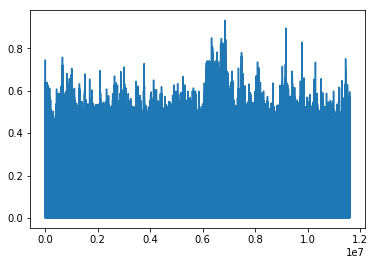

In [38]:
longflare = lc_sim.lc_sim(2880*366*11,30,0.,'unbroken',[1.0, 8., 1.0, -1.])
longflare = np.abs(longflare)
STD = np.std(longflare)
longflare = 0.1*(longflare/STD)
print(STD)
print(np.std(longflare))
plt.plot(longflare)
plt.show()

0.130468460402
0.109405193655


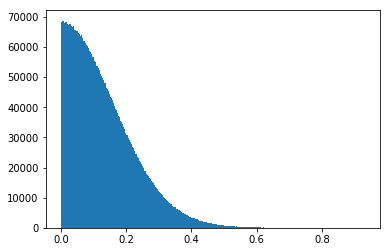

In [39]:
print(np.mean(longflare))
print(np.median(longflare))
number,bins,patches = plt.hist(longflare,bins='auto')
plt.show()
#plt.hist(longflare)

In [40]:
def plotPowerSpectrum(model,freqs,power,frequencyRange,period,LSperiod):
    
    #LSperiod = model.best_period


    fig, ax = plt.subplots()
    ax.plot((1/freqs), power)
    ax.plot((LSperiod),0.1,'ro')
    ax.plot(period,0.15,'bo')
    ax.set(yscale='log',
           xscale='log',
           xlabel='Period',
           ylabel='Lomb-Scargle Power',
          title='Period = '+str(period)+', MeasuredPeriod = '+str(LSperiod));
    #plt.savefig('rMag'+str(objectmag[3])+'Period'+str(period)+graphtitle+'.png')
    plt.show()
    
    print('actual',period,'measured',model.best_period)
    print( model.optimizer.period_range)

In [58]:
def lombScargle(frequencyRange,graphtitle='Oops',longflare=longflare,objectmag=20,loopNo=looooops,numsteps=10000): # frequency range and object mag in list
    
    t0 = time.time()
    
    results = {}
    totperiod,totmperiod,totpower,SigLevel = [],[],[],[] # resetSigLevel = []
    filterletter = ['o','u','g','r','i','z','y']
    
    period = 1/(frequencyRange) 
    half = frequencyRange*0.5
    double = frequencyRange*2
    
    fmin=(1/3)  #0.02 #0.5*frequencyRange#
    fmax=(1/0.003) #300 #2*frequencyRange
    
    df = (fmax-fmin)/numsteps
    modulationAmplitude=0.1
    
    measuredpower = [] # reset
    #for 
    #y = np.zeros((7,1))
    y = [[], [], [], [], [], [], []]
    #y = np.array([[0], [0], [0], [0], [0], [0], [0]]) # for looping only
    for z in range(1, len(y)):
        y[z] = modulationAmplitude*(ellipsoidalFlux(obs[z], frequencyRange,30))
        #y[z] = [modulationAmplitude * t for t in y[z]] # scaling
        for G in range(0, len(y[z])):
            flareMinute = int(round(((obs[z][G]-obs[0][0])*24*60*2)))
            y[z][G] = y[z][G] + longflare[flareMinute] # add flares swapped to second but not changing the name intrtoduces fewer bugs
    t1 = time.time()
    print('Making Lightcurve',(t1-t0))
    y = np.asarray(y)
    date,amplitude,mag,error,filts = [],[],[],[],[]
    for z in range(1, len(y)):
        if objectmag[z] > sat[z] and objectmag[z] < lim[z]:
            if z == 3:
                dater = obs[z]
                magr = [objectmag[z] - t for t in amplitude]
            #date.extend([x for x in obs[z]])
            date.extend(obs[z])
            amplitude = y[z] + random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z]))
            #amplitude = [t + random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise
            mag.extend(objectmag[z] - amplitude)
            #mag.extend([objectmag[z] - t for t in amplitude]) # add actual mag
            error.extend([sigSys + magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])+0.2]*len(amplitude))
            filts.extend([filterletter[z]]*len(amplitude))
            
            
#             phase = (obs[z] % (period*2))/(period*2)
#             phase = [(day % (period*2))/(period*2) for day in obs[z]]
#             pmag = [objectmag[z] - t for t in amplitude]
#         plt.plot(phase, pmag, 'o', markersize=4)
#         plt.xlabel('Phase')
#         plt.ylabel('Magnitude')
#         plt.gca().invert_yaxis()
#         plt.title('filter'+str(z)+', Period = '+str(period))#+', MeasuredPeriod = '+str(LSperiod)+', Periodx20 = '+(str(period*20)))
#         plt.show()

#     plt.plot(date, mag, 'o')
# #     lower = date[30]
# #     higher = date[30]+(5*period)
# #     plt.xlim(lower,higher)
#     plt.xlabel('time (days)')
#     plt.ylabel('mag')
#     plt.gca().invert_yaxis()
#     plt.show()
    #baseline = 110
    #baseline = date[-1]-date[0]
    date = np.asarray(date)
    mag = np.asarray(mag)
    filts = np.asarray(filts)
    error = np.asarray(error)
    
    t2 = time.time()
    print('formating', (t2-t1))
    
    model = periodic.LombScargleMultibandFast(fit_period=False)
    model.optimizer.period_range=(0.003, 0.1)
    model.fit(date, mag, error, filts)
    
    t3 = time.time()
    print('making model', (t3-t2))
    
    LSperiod = model.best_period
    print(LSperiod)
    
    t4 = time.time()
    print('find Period', t4-t3)
    
    df = (1/LSperiod)/numsteps
    fmin = 0.5*(1/LSperiod)
    
    freqs = fmin + df * np.arange(numsteps)
    
    #freqs = fmin + df * np.arange(numsteps) 
    power = model.score_frequency_grid(fmin, df, numsteps) 
    maxpowerlow = power.max()
    position = np.where(power==maxpowerlow)
    Top = np.argsort(power)[-5:]
    for i,item in enumerate(Top):
        print('Freq'+str(i),freqs[item])
    altPeriod = 1/freqs[position]
    print('Second Period',altPeriod)
    
    timearoni = time.time()
    print('Second Period Time',(timearoni-t4))
    
    #print(model.best_scores)

    fig, ax = plt.subplots()
    ax.plot(freqs, power)
    ax.plot((1/LSperiod),0.1,'ro')
    ax.set(yscale='log',
           xscale='log',
           xlabel='Frequency',
           ylabel='Lomb-Scargle Power',
          title='Frequency = '+str(frequencyRange)+', MeasuredFrequency = '+str(1/LSperiod));
    #plt.savefig('rMagPeriod.png')
    plt.show()
    
    t5 = time.time()
    print ('Plot Lightcurve', (t5-t4))
    
    #plotPowerSpectrum(model,freqs,power,frequencyRange,period,LSperiod)
    
#     freqs = np.logspace(np.log10(fmin),np.log10(fmax),numsteps)
#     power = model.score_frequency_grid(fmin, df, numsteps) 
#     plotPowerSpectrum(model,freqs,power,frequencyRange,period)

    #phase = [(day % (period*2))/(period*2) for day in date]
    #idealphase = [(day % (period*2))/(period*2) for day in dayZ]
    #print(len(phase),len(idealphase))
    #plt.plot(idealphase,Zmag,'ko',)
#     plt.plot(phase, mag, 'o', markersize=4)
#     plt.xlabel('Phase')
#     plt.ylabel('Magnitude')
#     plt.gca().invert_yaxis()
#     plt.title('Period = '+str(period)+', MeasuredPeriod = '+str(LSperiod)+', Periodx20 = '+(str(period*20)))
#     plt.show()
    #print(period, LSperiod, period*20)

    mpower = power.max()
    measuredpower.append(power.max()) # should this correspond to period power and not max power?
    maxpower = []           
    counter = 0.
    for loop in range(0,loopNo):
        random.shuffle(date)
        model = periodic.LombScargleMultibandFast(fit_period=False)
        model.fit(date, mag, error, filts)
        power = model.score_frequency_grid(fmin, df, numsteps)  
        maxpower.append(power.max())
    t6 = time.time()
    print('looping', (t6-t5))
    
    for X in range(0, len(maxpower)):
        if maxpower[X] > measuredpower[-1]:
            counter = counter + 1. 
    Significance = (1.-(counter/len(maxpower)))
    SigLevel.append(Significance)
    
    results[0] = objectmag[3]
    results[1] = period
    results[2] = LSperiod
    results[3] = Significance
    results[4] = mpower
    results[5] = 0#listnumber
    return results

In [59]:
# tfit = np.linspace(0, model.best_period, 1000)
# filtsfit = np.array(list('ugriz'))[:, np.newaxis]
# magfit = model.predict(tfit, filts=filtsfit)
# for single filter stuff


11594880


/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in remainder


('Making Lightcurve', 3.6075661182403564)
('formating', 0.3099479675292969)
('making model', 0.10039210319519043)
Finding optimal frequency:
 - Estimated peak width = 0.00172
 - Using 5 steps per peak; omega_step = 0.000344
 - User-specified period range:  0.003 to 0.1
 - Computing periods at 5904876 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
[ 0.00325651]
('find Period', 192.27755284309387)
('Freq0', 244.02230127891892)
('Freq1', 449.65990009406102)
('Freq2', 430.46754886217263)
('Freq3', 153.53880985510716)
('Freq4', 307.07761971021432)
('Second Period', array([ 0.00325651]))
('Second Period Time', 2.664677143096924)


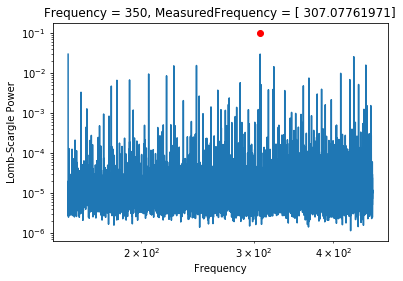

('Plot Lightcurve', 4.225717067718506)
('looping', 3.0878729820251465)
('Making Lightcurve', 3.3210229873657227)
('formating', 0.28936100006103516)
('making model', 0.09768319129943848)
Finding optimal frequency:
 - Estimated peak width = 0.00172
 - Using 5 steps per peak; omega_step = 0.000344
 - User-specified period range:  0.003 to 0.1
 - Computing periods at 5904876 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
[ 0.00303454]
('find Period', 189.83948493003845)
('Freq0', 453.45199200479254)
('Freq1', 311.42735608799956)
('Freq2', 297.73831396079277)
('Freq3', 329.53880903242145)
('Freq4', 164.76940451621073)
('Second Period', array([ 0.00606909]))
('Second Period Time', 2.456449031829834)


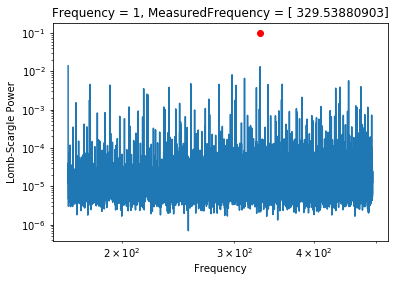

('Plot Lightcurve', 4.061140060424805)
('looping', 2.951119899749756)
('Making Lightcurve', 3.209829807281494)
('formating', 0.2856161594390869)
('making model', 0.09915399551391602)
Finding optimal frequency:
 - Estimated peak width = 0.00172
 - Using 5 steps per peak; omega_step = 0.000344
 - User-specified period range:  0.003 to 0.1
 - Computing periods at 5904876 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
[ 0.00305774]
('find Period', 188.93397784233093)
('Freq0', 286.72146609511879)
('Freq1', 327.03881067515141)
('Freq2', 204.96176342633089)
('Freq3', 409.92352685266178)
('Freq4', 163.51940533757571)
('Second Period', array([ 0.00611548]))
('Second Period Time', 2.3018510341644287)


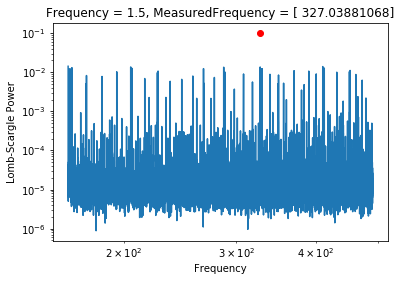

('Plot Lightcurve', 3.796849012374878)
('looping', 2.998547077178955)


In [63]:
import time

PrangeLoop = np.logspace(-2.5,2,freqlength)
FrangeLoop = [(1/x) for x in PrangeLoop]

FrangeLoop = [350,1,1.5,2,2.5]

noObs = 100000

obs = np.linspace(59630.320217,59630.320217+(365.25*10),noObs)
obs = obs.tolist()
obs = [obs]*7

#noObs = 'astro'

#obs = Observations.obsastro630
obs = np.asarray(obs)
for x in range(len(obs)):
    obs[x] = np.asarray(obs[x])


results = []
# fullmeasuredPeriod = []
# fullPeriod = []
# fullPower = []
# fullSigLevel = []
# fullMag = []
# MagRangearray = np.linspace(17,24,maglength)
# MagRange = [x for x in MagRangearray]
# maglist = []
# for x in range(len(MagRange)):
#     maglist.append([MagRange[x]]*7)

#newlist = np.linspace(59630,(10*365),10000)
#newlist = newlist.tolist()
#newlist = [newlist]*7
#print(len(newlist))
newlist = Magnitudes.mag630

print(len(longflare))
FrangeLoop = FrangeLoop
#lombScargle(FrangeLoop[0],objectmag=newlist[0])

#pool = Pool(processors)
for h in range(startnumber,endnumber):
    for i in range(3):
        results.append(lombScargle(FrangeLoop[i],objectmag=newlist[h],graphtitle=str(noObs),numsteps=50000)) 
    #print(newlist[h])
    #results.append(pool.map(partial(lombScargle, objectmag=newlist[h],graphtitle=str(noObs)),FrangeLoop))


In [64]:
1/0.00606909

164.76934762872193

In [ ]:
noObs = 100000

obs = np.linspace(59630.320217,59630.320217+(365.25*10),noObs)
obs = obs.tolist()
obs = [obs]*7

results = []
fullmeasuredPeriod = []
fullPeriod = []
fullPower = []
fullSigLevel = []
fullMag = []
MagRangearray = np.linspace(17,24,maglength)
MagRange = [x for x in MagRangearray]
maglist = []
for x in range(len(MagRange)):
    maglist.append([MagRange[x]]*7)

#newlist = np.linspace(59630,(10*365),10000)
#newlist = newlist.tolist()
#newlist = [newlist]*7
#print(len(newlist))
newlist = Magnitudes.mag630

print(len(longflare))
FrangeLoop = FrangeLoop[0:3]
#lombScargle(FrangeLoop[0],objectmag=newlist[0])

pool = Pool(processors)
for h in range(startnumber,endnumber):
    #print(newlist[h])
    results.append(pool.map(partial(lombScargle, objectmag=newlist[h],graphtitle=str(noObs)),FrangeLoop))
    
    twoDlist = [[],[],[],[],[],[]]
    for X in range(len(results)):
        for Y in range(len(results[X])):
            twoDlist[0].append(results[X][Y][0])
            twoDlist[1].append(results[X][Y][1])
            twoDlist[2].append(results[X][Y][2])
            twoDlist[3].append(results[X][Y][3])
            twoDlist[4].append(results[X][Y][4])
            twoDlist[5].append(results[X][Y][5])
    with open(inFile, 'r') as istr:
        with open(outFile,'w') as ostr:
            for i, line in enumerate(istr):
                # Get rid of the trailing newline (if any).
                line = line.rstrip('\n')
                if i % 2 != 0:
                    line += str(twoDlist[int((i-1)/2)])+','
                ostr.write(line+'\n')


In [ ]:
noObs = 1000000 

obs = np.linspace(59630.320217,59630.320217+(365.25*10),noObs)
obs = obs.tolist()
obs = [obs]*7

results = []
fullmeasuredPeriod = []
fullPeriod = []
fullPower = []
fullSigLevel = []
fullMag = []
MagRangearray = np.linspace(17,24,maglength)
MagRange = [x for x in MagRangearray]
maglist = []
for x in range(len(MagRange)):
    maglist.append([MagRange[x]]*7)

#newlist = np.linspace(59630,(10*365),10000)
#newlist = newlist.tolist()
#newlist = [newlist]*7
#print(len(newlist))
newlist = Magnitudes.mag630

print(len(longflare))
FrangeLoop = FrangeLoop[0:3]
#lombScargle(FrangeLoop[0],objectmag=newlist[0])

pool = Pool(processors)
for h in range(startnumber,endnumber):
    #print(newlist[h])
    results.append(pool.map(partial(lombScargle, objectmag=newlist[h],graphtitle=str(noObs)),FrangeLoop))
    
    twoDlist = [[],[],[],[],[],[]]
    for X in range(len(results)):
        for Y in range(len(results[X])):
            twoDlist[0].append(results[X][Y][0])
            twoDlist[1].append(results[X][Y][1])
            twoDlist[2].append(results[X][Y][2])
            twoDlist[3].append(results[X][Y][3])
            twoDlist[4].append(results[X][Y][4])
            twoDlist[5].append(results[X][Y][5])
    with open(inFile, 'r') as istr:
        with open(outFile,'w') as ostr:
            for i, line in enumerate(istr):
                # Get rid of the trailing newline (if any).
                line = line.rstrip('\n')
                if i % 2 != 0:
                    line += str(twoDlist[int((i-1)/2)])+','
                ostr.write(line+'\n')


In [ ]:
noObs = 10000000

obs = np.linspace(59630.320217,59630.320217+(365.25*10),noObs)
obs = obs.tolist()
obs = [obs]*7

results = []
fullmeasuredPeriod = []
fullPeriod = []
fullPower = []
fullSigLevel = []
fullMag = []
MagRangearray = np.linspace(17,24,maglength)
MagRange = [x for x in MagRangearray]
maglist = []
for x in range(len(MagRange)):
    maglist.append([MagRange[x]]*7)

#newlist = np.linspace(59630,(10*365),10000)
#newlist = newlist.tolist()
#newlist = [newlist]*7
#print(len(newlist))
newlist = Magnitudes.mag630

print(len(longflare))
FrangeLoop = FrangeLoop[0:3]
#lombScargle(FrangeLoop[0],objectmag=newlist[0])

pool = Pool(processors)
for h in range(startnumber,endnumber):
    #print(newlist[h])
    results.append(pool.map(partial(lombScargle, objectmag=newlist[h],graphtitle=str(noObs)),FrangeLoop))
    
    twoDlist = [[],[],[],[],[],[]]
    for X in range(len(results)):
        for Y in range(len(results[X])):
            twoDlist[0].append(results[X][Y][0])
            twoDlist[1].append(results[X][Y][1])
            twoDlist[2].append(results[X][Y][2])
            twoDlist[3].append(results[X][Y][3])
            twoDlist[4].append(results[X][Y][4])
            twoDlist[5].append(results[X][Y][5])
    with open(inFile, 'r') as istr:
        with open(outFile,'w') as ostr:
            for i, line in enumerate(istr):
                # Get rid of the trailing newline (if any).
                line = line.rstrip('\n')
                if i % 2 != 0:
                    line += str(twoDlist[int((i-1)/2)])+','
                ostr.write(line+'\n')


In [ ]:
noObs = 'astro'

obs = Observations.obsastro630

results = []
fullmeasuredPeriod = []
fullPeriod = []
fullPower = []
fullSigLevel = []
fullMag = []
MagRangearray = np.linspace(17,24,maglength)
MagRange = [x for x in MagRangearray]
maglist = []
for x in range(len(MagRange)):
    maglist.append([MagRange[x]]*7)

#newlist = np.linspace(59630,(10*365),10000)
#newlist = newlist.tolist()
#newlist = [newlist]*7
#print(len(newlist))
newlist = Magnitudes.mag630

print(len(longflare))
FrangeLoop = FrangeLoop[0:3]
#lombScargle(FrangeLoop[0],objectmag=newlist[0])

pool = Pool(processors)
for h in range(startnumber,endnumber):
    #print(newlist[h])
    results.append(pool.map(partial(lombScargle, objectmag=newlist[h],graphtitle=str(noObs)),FrangeLoop))
    
    twoDlist = [[],[],[],[],[],[]]
    for X in range(len(results)):
        for Y in range(len(results[X])):
            twoDlist[0].append(results[X][Y][0])
            twoDlist[1].append(results[X][Y][1])
            twoDlist[2].append(results[X][Y][2])
            twoDlist[3].append(results[X][Y][3])
            twoDlist[4].append(results[X][Y][4])
            twoDlist[5].append(results[X][Y][5])
    with open(inFile, 'r') as istr:
        with open(outFile,'w') as ostr:
            for i, line in enumerate(istr):
                # Get rid of the trailing newline (if any).
                line = line.rstrip('\n')
                if i % 2 != 0:
                    line += str(twoDlist[int((i-1)/2)])+','
                ostr.write(line+'\n')


In [ ]:
results = []
fullmeasuredPeriod = []
fullPeriod = []
fullPower = []
fullSigLevel = []
fullMag = []
MagRangearray = np.linspace(17,24,maglength)
MagRange = [x for x in MagRangearray]
maglist = []
for x in range(len(MagRange)):
    maglist.append([MagRange[x]]*7)

#newlist = np.linspace(59630,(10*365),10000)
#newlist = newlist.tolist()
#newlist = [newlist]*7
#print(len(newlist))
newlist = Magnitudes.mag630

print(len(longflare))
FrangeLoop = FrangeLoop[0:3]
#lombScargle(FrangeLoop[0],objectmag=newlist[0])

pool = Pool(processors)
for h in range(startnumber,endnumber):
    #print(newlist[h])
    results.append(pool.map(partial(lombScargle, objectmag=newlist[h]),FrangeLoop))
    
    twoDlist = [[],[],[],[],[],[]]
    for X in range(len(results)):
        for Y in range(len(results[X])):
            twoDlist[0].append(results[X][Y][0])
            twoDlist[1].append(results[X][Y][1])
            twoDlist[2].append(results[X][Y][2])
            twoDlist[3].append(results[X][Y][3])
            twoDlist[4].append(results[X][Y][4])
            twoDlist[5].append(results[X][Y][5])
    with open(inFile, 'r') as istr:
        with open(outFile,'w') as ostr:
            for i, line in enumerate(istr):
                # Get rid of the trailing newline (if any).
                line = line.rstrip('\n')
                if i % 2 != 0:
                    line += str(twoDlist[int((i-1)/2)])+','
                ostr.write(line+'\n')


In [ ]:
obs = np.linspace(59630.320217,59630.320217+(365.25*10),300)
obs = obs.tolist()
obs = [obs]*7
#In[19]:

results = []
fullmeasuredPeriod = []
fullPeriod = []
fullPower = []
fullSigLevel = []
fullMag = []
MagRangearray = np.linspace(17,24,maglength)
MagRange = [x for x in MagRangearray]
maglist = []
for x in range(len(MagRange)):
    maglist.append([MagRange[x]]*7)

#newlist = np.linspace(59630,(10*365),10000)
#newlist = newlist.tolist()
#newlist = [newlist]*7
#print(len(newlist))
newlist = Magnitudes.mag630

#lombScargle(FrangeLoop[0],objectmag=newlist[0])

pool = Pool(processors)
for h in range(startnumber,endnumber):
    #print(newlist[h])
    results.append(pool.map(partial(lombScargle, objectmag=newlist[h]),FrangeLoop))
    
    twoDlist = [[],[],[],[],[],[]]
    for X in range(len(results)):
        for Y in range(len(results[X])):
            twoDlist[0].append(results[X][Y][0])
            twoDlist[1].append(results[X][Y][1])
            twoDlist[2].append(results[X][Y][2])
            twoDlist[3].append(results[X][Y][3])
            twoDlist[4].append(results[X][Y][4])
            twoDlist[5].append(results[X][Y][5])
    with open(inFile, 'r') as istr:
        with open(outFile,'w') as ostr:
            for i, line in enumerate(istr):
                # Get rid of the trailing newline (if any).
                line = line.rstrip('\n')
                if i % 2 != 0:
                    line += str(twoDlist[int((i-1)/2)])+','
                ostr.write(line+'\n')


In [ ]:
obs = np.linspace(59630.320217,59630.320217+(365.25*10),300)
obs = obs.tolist()
obs = [obs]*7
#In[19]:

results = []
fullmeasuredPeriod = []
fullPeriod = []
fullPower = []
fullSigLevel = []
fullMag = []
MagRangearray = np.linspace(17,24,maglength)
MagRange = [x for x in MagRangearray]
maglist = []
for x in range(len(MagRange)):
    maglist.append([MagRange[x]]*7)

#newlist = np.linspace(59630,(10*365),10000)
#newlist = newlist.tolist()
#newlist = [newlist]*7
#print(len(newlist))
newlist = Magnitudes.mag630


In [ ]:
def ellipsoidalFlux(observations,Frequency,exptime):
    period = 1/(Frequency)
    #print(period)
    phase = [(x % (2*period)) for x in observations]
    b = [0.]*len(observations)
    b = np.asarray(b)
    for seconds in range(0, exptime):
        a = [np.sin((2*np.pi*(Frequency))*(x+(seconds/(3600*24)))) for x in observations] # optical modulation
        b += a
    #print(b)
    observations = np.asarray(observations)
    mag = np.sin(2*np.pi*Frequency*observations)
    plt.plot(observations,mag,'o')
    plt.show()
    c = b/exptime
    plt.plot(observations,c,'o')
    plt.show()
#     for x in range(0,len(phase)):
#         if (phase[x]+(1.5*period)) < (3*period):
#             c[x] = c[x]*(1./3.)
#         else:
#             c[x] = c[x]*(2./3.)
    return c



In [ ]:
Obs = np.linspace(59630.320217,59630.320217+(100),5000)
plt.plot(Obs,'o')
plt.show()
frequency = 1
ellipsoidal = ellipsoidalFlux(Obs,frequency,30)


In [ ]:
b = [0,0,0]
b = np.asarray(b)
for x in range(10):
    b += a
    print(b[0])
print(b)
    #c = [1,2,3]
    #d= [0.5,0.7,0.8]


In [ ]:
def graphMaker(Obs,frequency,mag):
    
#     ellipsoidal = [[]]*len(obs)
#     ellipNorm = [[]]*len(obs)
    modulationAmplitude = 0.1
    #for y in range(len(Obs)):
    ellipsoidal = ellipsoidalFlux(Obs,frequency,30)

    ellipNorm = [modulationAmplitude * t for t in ellipsoidal] 

    ellipNorm = [17+x for x in ellipNorm]

#    scatter = []
#     for G in range(0, len(Obs)):
#         flareMinute = int(round(((Obs[G]-Obs[0])*24*60)))
#         if flareMinute == len(longflare):
#             flareMinute += -1
                    
                
#         scatter.append(longflare[flareMinute])
        
#         #ellipNorm[G] += longflare[flareMinute]
#     #print(scatter)    
    #plt.plot(Obs,ellipNorm,'o')
    plt.title('Light Curve: Period = '+str(1/frequency))
    plt.xlabel('Time (days)')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()
    plt.show()
#     print(np.mean(scatter))
#     print(np.std(scatter))
#     plt.plot(Obs,ellipNorm)
#     plt.title('Light Curve: Period = '+str(1/frequency))
#     plt.xlim([Obs[30],Obs[45]])
#     plt.xlabel('Time (days)')
#     plt.ylabel('Magnitude')
#     plt.gca().invert_yaxis()
#     plt.show()

In [ ]:
#obs = np.linspace(59630.320217,59630.320217+(365.25*10),1000)
obs = Observations.obsminion630

for y in range(len(FrangeLoop)):
    graphMaker(obs[0],FrangeLoop[y],newlist[0][0])

In [ ]:
(obs[0][-1]-obs[0][0])*24*60

In [ ]:
len(longflare)

In [26]:
np.log10(0.0031)

-2.5086383061657274

In [22]:
np.exp(-2.5)

0.0820849986238988

In [28]:
np.log10(25)

1.3979400086720377

In [19]:
np.log10(0.0012)

-2.9208187539523753

In [29]:
0.0031*60*24

4.464